<a href="https://colab.research.google.com/github/Richardhzj/ML/blob/main/GCN/GCN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=16452bc9ea47230cdb4a05b28ae28a10710f5146eb2edc9a72ae2c92b38426fe
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [15]:
from torch_geometric.utils import undirected
# paper reference dataset.
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="/",name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}')
print()
print(f'number of graphs: {len(dataset)}')
print(f'number of features: {dataset.num_features}')
print(f'number of classes: {dataset.num_classes}')

data = dataset[0]

print()
print(data)
print()

print(f'number of nodes: {data.num_nodes}')
print(f'number of edges: {data.num_edges}')
print(f'average code degree:{data.num_edges/data.num_nodes:.2f}')
print(f'number of training nodes: {data.train_mask.sum()}')
print(f'training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'has isolated nodes: {data.has_isolated_nodes()}')
print(f'hasself-loops: {data.has_self_loops()}')
print(f'is undirected: {data.is_undirected()}')


Dataset: Cora()

number of graphs: 1
number of features: 1433
number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

number of nodes: 2708
number of edges: 10556
average code degree:3.90
number of training nodes: 140
training node label rate: 0.05
has isolated nodes: False
hasself-loops: False
is undirected: True


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(10,10))
  plt.xticks([])
  plt.xticks([])

  plt.scatter(z[:,0], z[:,1], s=70,c=color, cmap="Set2")
  plt.show()

# try MLP first, comparing to GCN

In [24]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(123)
    self.l1 = Linear(dataset.num_features,hidden_channels) # 1433,16
    self.l2 = Linear(hidden_channels,dataset.num_classes)

  def forward(self, x):
    x = self.l1(x)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.l2(x)
    return x
model = MLP(16)
print(model)

MLP(
  (l1): Linear(in_features=1433, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=7, bias=True)
)


In [51]:
model = MLP(16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum())/int(data.test_mask.sum())
  return test_acc

for epoch in range(201):
  loss= train()
  print(f'Epoch: {epoch:03d}. Loss: {loss:.4f}')

Epoch: 000. Loss: 1.9575
Epoch: 001. Loss: 1.9542
Epoch: 002. Loss: 1.9512
Epoch: 003. Loss: 1.9442
Epoch: 004. Loss: 1.9368
Epoch: 005. Loss: 1.9297
Epoch: 006. Loss: 1.9222
Epoch: 007. Loss: 1.9174
Epoch: 008. Loss: 1.8998
Epoch: 009. Loss: 1.8926
Epoch: 010. Loss: 1.8864
Epoch: 011. Loss: 1.8703
Epoch: 012. Loss: 1.8613
Epoch: 013. Loss: 1.8454
Epoch: 014. Loss: 1.8371
Epoch: 015. Loss: 1.8139
Epoch: 016. Loss: 1.8158
Epoch: 017. Loss: 1.7973
Epoch: 018. Loss: 1.7645
Epoch: 019. Loss: 1.7479
Epoch: 020. Loss: 1.7152
Epoch: 021. Loss: 1.6847
Epoch: 022. Loss: 1.7035
Epoch: 023. Loss: 1.6662
Epoch: 024. Loss: 1.6559
Epoch: 025. Loss: 1.5904
Epoch: 026. Loss: 1.6043
Epoch: 027. Loss: 1.5922
Epoch: 028. Loss: 1.5725
Epoch: 029. Loss: 1.5178
Epoch: 030. Loss: 1.5406
Epoch: 031. Loss: 1.5155
Epoch: 032. Loss: 1.4403
Epoch: 033. Loss: 1.4341
Epoch: 034. Loss: 1.4584
Epoch: 035. Loss: 1.3916
Epoch: 036. Loss: 1.3620
Epoch: 037. Loss: 1.3154
Epoch: 038. Loss: 1.2874
Epoch: 039. Loss: 1.2704


In [53]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


Try GNN

In [56]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(123)
    self.conv1 = GCNConv(dataset.num_features,hidden_channels)
    self.conv2 = GCNConv(hidden_channels,dataset.num_classes)

  def forward(self,x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x
model = GCN(16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


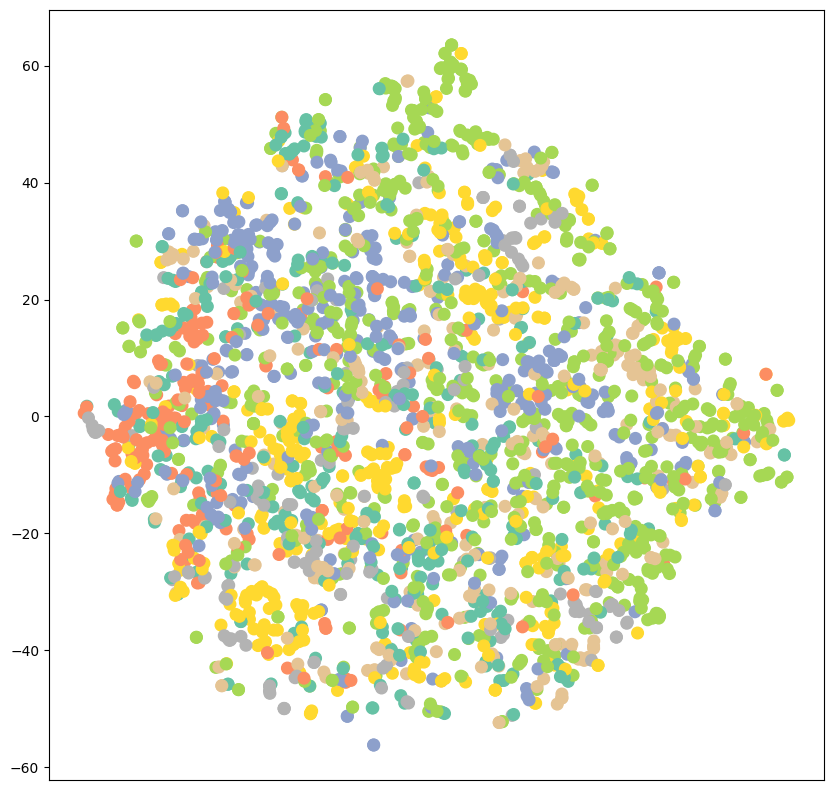

In [57]:
# visualization
model = GCN(16)
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [59]:
model = GCN(16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x,data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x,data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum())/int(data.test_mask.sum())
  return test_acc

for epoch in range(201):
  loss= train()
  print(f'Epoch: {epoch:03d}. Loss: {loss:.4f}')

Epoch: 000. Loss: 1.9459
Epoch: 001. Loss: 1.9396
Epoch: 002. Loss: 1.9323
Epoch: 003. Loss: 1.9223
Epoch: 004. Loss: 1.9149
Epoch: 005. Loss: 1.9055
Epoch: 006. Loss: 1.8937
Epoch: 007. Loss: 1.8832
Epoch: 008. Loss: 1.8763
Epoch: 009. Loss: 1.8606
Epoch: 010. Loss: 1.8484
Epoch: 011. Loss: 1.8333
Epoch: 012. Loss: 1.8202
Epoch: 013. Loss: 1.8088
Epoch: 014. Loss: 1.7818
Epoch: 015. Loss: 1.7771
Epoch: 016. Loss: 1.7684
Epoch: 017. Loss: 1.7524
Epoch: 018. Loss: 1.7226
Epoch: 019. Loss: 1.7143
Epoch: 020. Loss: 1.6900
Epoch: 021. Loss: 1.6840
Epoch: 022. Loss: 1.6543
Epoch: 023. Loss: 1.6338
Epoch: 024. Loss: 1.6358
Epoch: 025. Loss: 1.6041
Epoch: 026. Loss: 1.5706
Epoch: 027. Loss: 1.5626
Epoch: 028. Loss: 1.5327
Epoch: 029. Loss: 1.5231
Epoch: 030. Loss: 1.5246
Epoch: 031. Loss: 1.4767
Epoch: 032. Loss: 1.4694
Epoch: 033. Loss: 1.4643
Epoch: 034. Loss: 1.4106
Epoch: 035. Loss: 1.4046
Epoch: 036. Loss: 1.4094
Epoch: 037. Loss: 1.3249
Epoch: 038. Loss: 1.3557
Epoch: 039. Loss: 1.3349


In [60]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8030


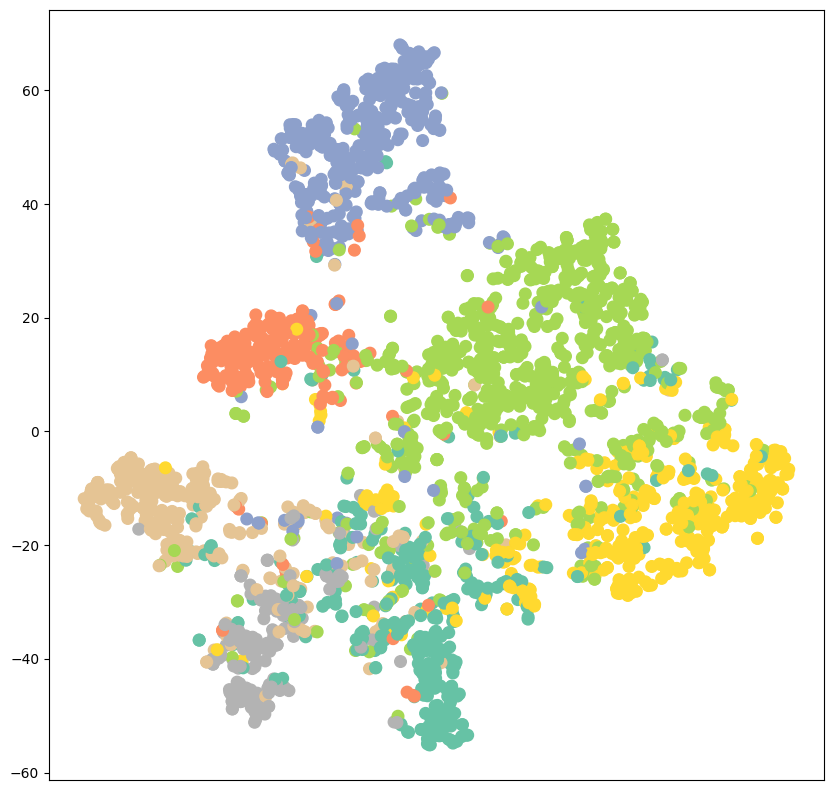

In [61]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)